# Lagged cross-covariance analysis

Resolution: 5-degree, daily

---

In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import xarray

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

import stats 
import data_utils as utils
import plotting as plot

In [3]:
# %load_ext autoreload
# %autoreload 2

In [4]:
DS_sif = xarray.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc")
DS_xco2 = xarray.open_dataset("../data/exp_pro/OCO2_Lite_XCO2_land.nc")

In [5]:
# Cut datasets to a regular grid and resample to daily averages within each grid cell
df_sif_daily = (
    utils.regrid(DS_sif, res=5)
    .groupby(["lon", "lat"])
    .resample("1D")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)
df_xco2_daily = (
    utils.regrid(DS_xco2, res=5)
    .groupby(["lon", "lat"])
    .resample("1D")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)

# Merge dataframes
df_grid_daily = pd.merge(df_sif_daily, df_xco2_daily, on=["lon", "lat", "time"], how="outer")
df_grid_daily

,lon,lat,time,sif,xco2
0,-177.5,-87.5,2014-11-27,0.071730,NaN
1,-177.5,-87.5,2014-11-28,NaN,NaN
2,-177.5,-87.5,2014-11-29,0.058615,NaN
3,-177.5,-87.5,2014-11-30,-0.068265,NaN
4,-177.5,-87.5,2014-12-01,NaN,NaN
...,...,...,...,...,...
2845293,167.5,-42.5,2014-09-16,NaN,NaN
2845294,167.5,-42.5,2014-09-17,NaN,NaN
2845295,167.5,-42.5,2014-09-18,NaN,NaN
2845296,167.5,-42.5,2014-09-19,NaN,NaN


In [6]:
# Convert to dataset and compute statistics
DS_grid_daily = stats.get_stats(
    df_grid_daily
    .set_index(["lon", "lat", "time"])
    .to_xarray()
)

DS_grid_daily["xcor_lag1"] = stats.apply_xcor(DS_grid_daily.xco2, DS_grid_daily.sif, lag=30, tau=30)
DS_grid_daily["xcor_lag2"] = stats.apply_xcor(DS_grid_daily.xco2, DS_grid_daily.sif, lag=60, tau=30)

DS_grid_daily

/home/josh/Projects/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/josh/Projects/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<xarray.Dataset>
Dimensions:     (lat: 35, lon: 72, time: 2156)
Coordinates:
  * lon         (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat         (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 67.5 72.5 77.5 82.5
  * time        (time) datetime64[ns] 2014-09-06 2014-09-07 ... 2020-07-31
Data variables:
    sif         (lon, lat, time) float32 nan nan nan nan nan ... nan nan nan nan
    xco2        (lon, lat, time) float32 nan nan nan nan nan ... nan nan nan nan
    sif_count   (lon, lat) int64 101 283 0 0 0 0 0 0 0 ... 0 55 0 306 398 74 0 0
    xco2_count  (lon, lat) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 78 125 0 0 0
    sif_slope   (lon, lat) float64 5.766e-05 -1.917e-05 nan ... nan nan
    xco2_slope  (lon, lat) float64 nan nan nan nan nan ... 0.008633 nan nan nan
    sif_std     (lon, lat) float64 0.1844 0.2186 nan nan ... 0.112 0.109 nan nan
    xco2_std    (lon, lat) float64 nan nan nan nan nan ... 3.289 nan nan nan
    xcor_lag1   (lon, lat) float64 nan nan nan nan nan ... -0.08442 nan nan nan
    xcor_lag2   (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan

/home/josh/Projects/sif-data-fusion/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bwr"))


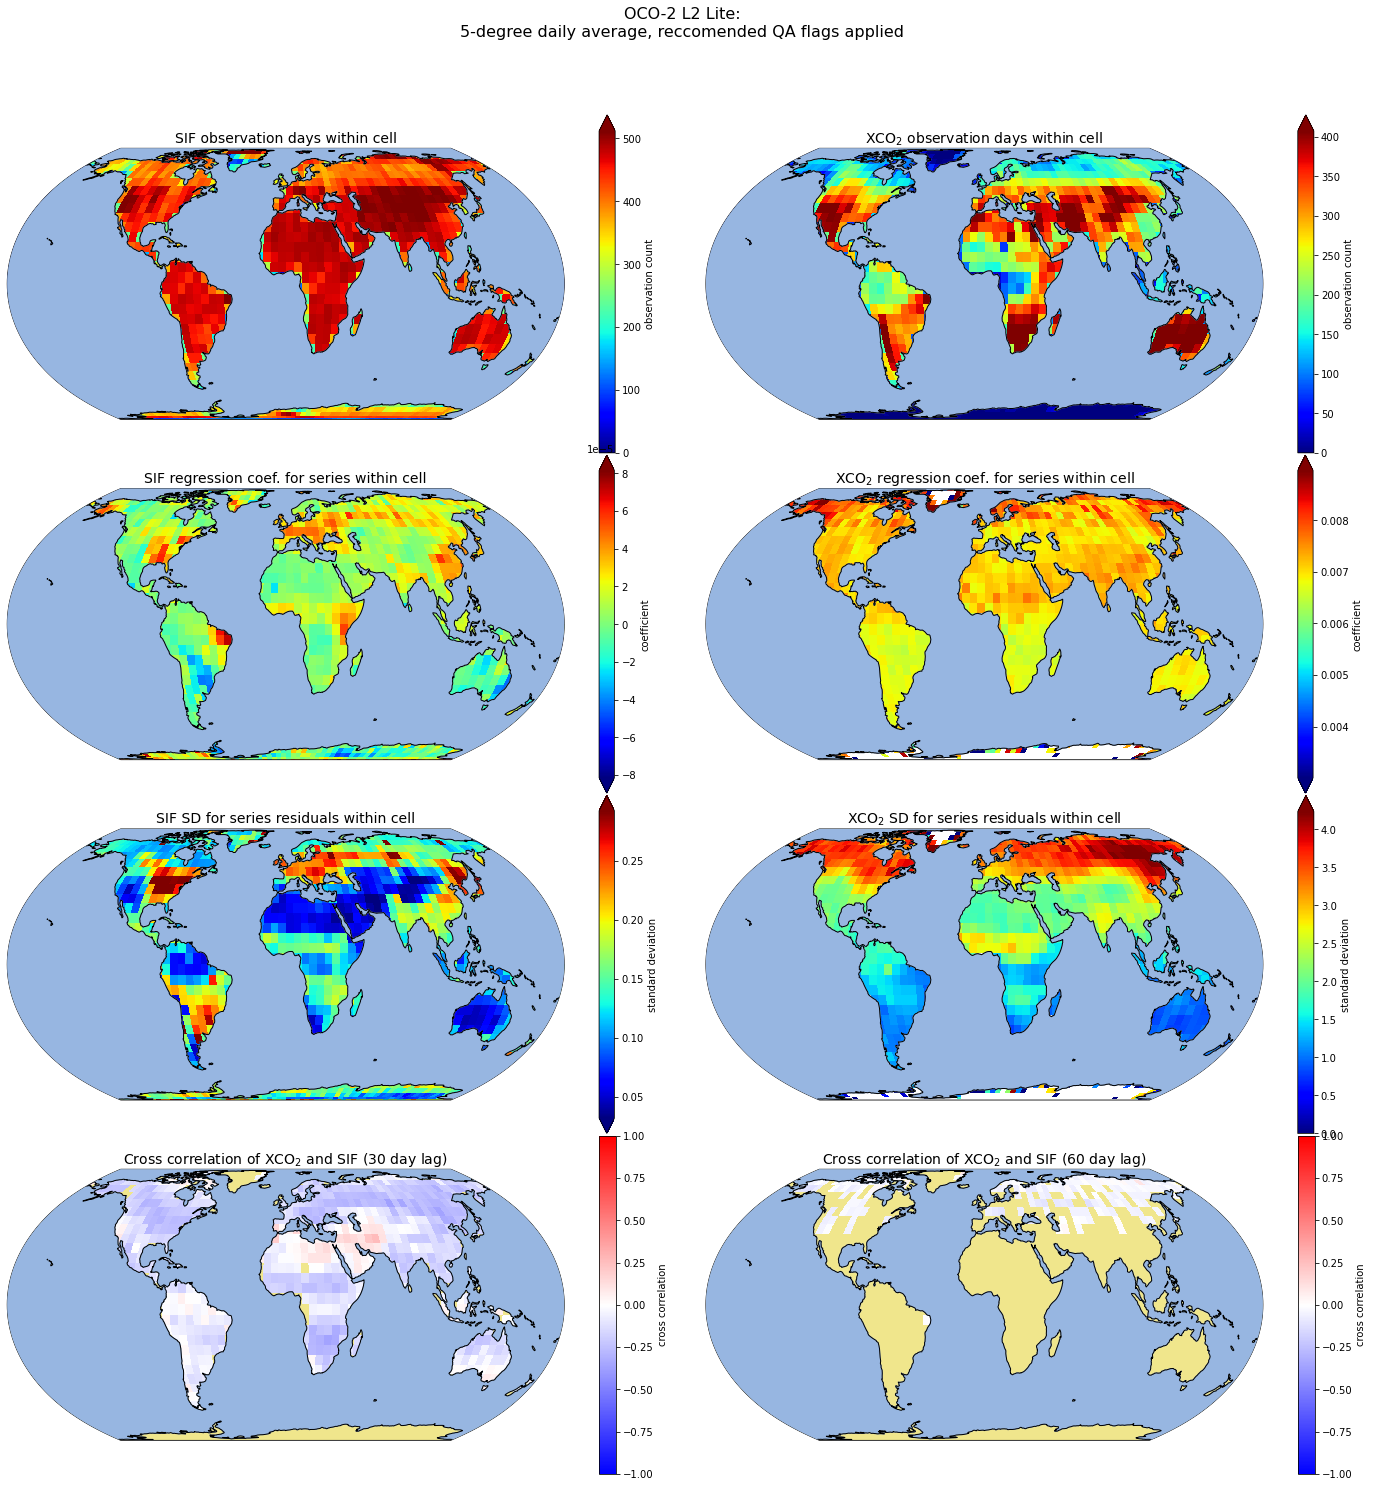

In [7]:
fig = plt.figure(figsize=(25, 25))
gs = fig.add_gridspec(100, 100)

# fig.subplots_adjust(top=0.8)
fig.suptitle(
    "OCO-2 L2 Lite:\n"
    "5-degree daily average, reccomended QA flags applied",
    size=16, y=0.94
)

# Counts
ax1 = fig.add_subplot(gs[:25, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:25, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_daily.sif_count,
    title="SIF observation days within cell",
    ax=ax1,
    cbar_kwargs={"label": "observation count"}
)
plot.plot_da(
    DS_grid_daily.xco2_count,
    title="XCO$_2$ observation days within cell",
    ax=ax2,
    cbar_kwargs={"label": "observation count"}
)

# Slopes
ax3 = fig.add_subplot(gs[25:50, 0:50], projection=ccrs.EqualEarth())
ax4 = fig.add_subplot(gs[25:50, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_daily.sif_slope,
    title="SIF regression coef. for series within cell",
    ax=ax3,
    cbar_kwargs={"label": "coefficient"}
)
plot.plot_da(
    DS_grid_daily.xco2_slope,
    title="XCO$_2$ regression coef. for series within cell",
    ax=ax4,
    cbar_kwargs={"label": "coefficient"}
)

# Standard deviation
ax5 = fig.add_subplot(gs[50:75, 0:50], projection=ccrs.EqualEarth())
ax6 = fig.add_subplot(gs[50:75, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_daily.sif_std,
    title="SIF SD for series residuals within cell",
    ax=ax5,
    cbar_kwargs={"label": "standard deviation"}
)
plot.plot_da(
    DS_grid_daily.xco2_std,
    title="XCO$_2$ SD for series residuals within cell",
    ax=ax6,
    cbar_kwargs={"label": "standard deviation"}
)

# Define color map with nans set to khaki
cmap = plt.get_cmap("bwr")
cmap.set_bad("khaki")

# Cross correlation
ax7 = fig.add_subplot(gs[75:, 0:50], projection=ccrs.EqualEarth())
ax8 = fig.add_subplot(gs[75:, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_daily.xcor_lag1,
    title="Cross correlation of XCO$_2$ and SIF (30 day lag)",
    ax=ax7,
    vmin=-1, vmax=1,
    cmap="bwr",
    cbar_kwargs={"label": "cross correlation"}
)
plot.plot_da(
    DS_grid_daily.xcor_lag2,
    title="Cross correlation of XCO$_2$ and SIF (60 day lag)",
    ax=ax8,
    vmin=-1, vmax=1,
    cmap="bwr",
    cbar_kwargs={"label": "cross correlation"}
)

fig.savefig("../plots/5deg_daily_panel.png");